# Monte Carlo Methods vs TD(λ) – Energy Consumption Optimization in Smart Buildings

## Abstract
This analysis serves as a comprehensive problem-solving report on applying Reinforcement Learning (RL) to smart building energy management. We investigate two distinct RL approaches: **Monte Carlo (MC) Control** and **Temporal Difference learning with eligibility traces (TD(λ))**. 

The objective is to optimize the operation of an HVAC (Heating, Ventilation, and Air Conditioning) system to maintain user comfort while minimizing energy consumption. We simulate a thermal environment and compare the algorithms' performance in terms of convergence speed, stability, and adaptability to non-stationary climate shifts (e.g., sudden weather changes).

## 1. Scenario Understanding and Problem Definition

### 1.1 The Smart Building Control Problem
Modern smart buildings aim to reduce their carbon footprint by optimizing energy usage without compromising occupant comfort. This is a sequential decision-making problem where the control system must decide heating or cooling actions based on the current state of the building (temperature, occupancy).

### 1.2 MDP Formulation
We model this scenario as a **Markov Decision Process (MDP)**, defined by the tuple $(S, A, P, R, \gamma)$:

*   **State Space ($S$)**: The state is a composite of the indoor temperature and occupancy.
    *   $T_{in}$: Continuous temperature discretized into 0.5°C bins (e.g., 18.0°C, 18.5°C, ...).
    *   $O$: Binary occupancy flag (1: Occupied, 0: Vacant).
*   **Action Space ($A$)**: Discrete control actions for the HVAC system.
    *   $A = \{-1, 0, +1\}$, corresponding to **Cooling**, **Off**, and **Heating**.
*   **Reward Function ($R$)**: The agent receives a scalar reward $R_t$ at each step, penalizing both energy use and thermal discomfort.
    *   $R_t = - (E_{cost} \cdot |a_t| + \lambda_{comfort} \cdot |T_{in} - T_{target}|)$
    *   We prioritize comfort when the room is occupied.
*   **Dynamics ($P$)**: The environment follows a simplified thermal RC (Resistor-Capacitor) model.
    *   $T_{t+1} = T_t + k(T_{out} - T_t) + P_{hvac} \cdot a_t + \epsilon$
    *   Where $k$ is the insulation factor, $T_{out}$ is the outdoor temperature, and $\epsilon$ is Gaussian noise.

### 1.3 Objective
The goal is to find an optimal policy $\pi^*(s)$ that maximizes the expected cumulative discounted reward:
$$ G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1} $$

## 2. Concept Explanation

### 2.1 Reinforcement Learning Basics
RL involves an agent learning through trial and error. The agent takes an action, observes a reward and a new state, and updates its internal estimates of "value" (how good a state or action is).

### 2.2 Monte Carlo (MC) Methods
Monte Carlo methods rely on **averaging sample returns**. They do not require knowledge of the environment's dynamics (model-free).
*   **Mechanism**: The agent plays out a full episode. At the end, it looks back and calculates the total return $G_t$ for each state visited.
*   **Update**: $V(S_t) \leftarrow V(S_t) + \alpha [G_t - V(S_t)]$
*   **Pros**: Unbiased estimates (since $G_t$ is the true return).
*   **Cons**: High variance; cannot learn online (must wait for episode end).

### 2.3 Temporal Difference (TD) Learning and Eligibility Traces
TD learning combines MC and Dynamic Programming. It updates estimates based on other estimates (**bootstrapping**).
*   **TD(0)**: Updates $V(S_t)$ using the immediate reward plus the value of the next state $V(S_{t+1})$.
*   **TD($\lambda$)**: A middle ground between TD(0) and MC. It uses **eligibility traces** ($e_t$) to assign credit to past states.
    *   **Eligibility Trace**: A temporary record of visited states. When a reward is received, states with high eligibility get a larger update.
    *   $e_t(s) = \gamma \lambda e_{t-1}(s) + \mathbb{I}(S_t=s)$
    *   $\lambda$ (Lambda): The decay rate. $\lambda=0$ is TD(0), $\lambda=1$ is MC.

### 2.4 Visualization: Understanding Eligibility Traces
The parameter $\lambda$ controls how fast the credit for a reward decays over time. 
*   High $\lambda$ (e.g., 0.9): Long-term memory. A reward now credits actions taken long ago.
*   Low $\lambda$ (e.g., 0.1): Short-term memory. Only recent actions are credited.

The plot below illustrates how the "eligibility" of a past state decays over time steps.

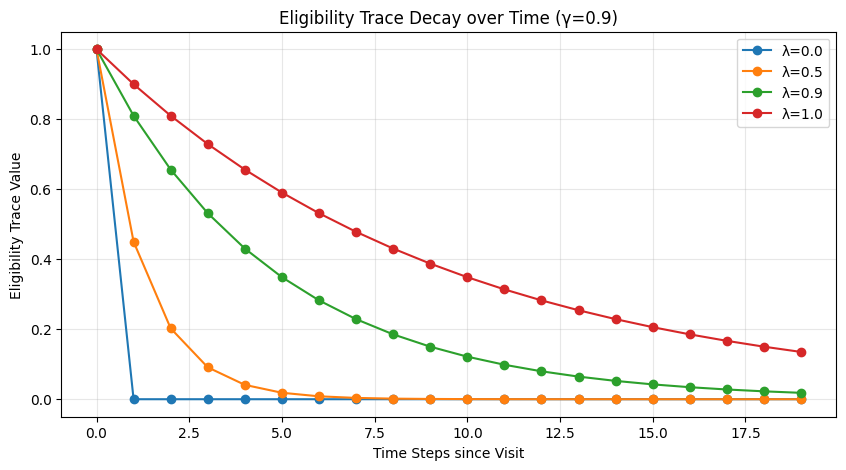

In [83]:
import matplotlib.pyplot as plt
import numpy as np

time_steps = np.arange(0, 20)
lambdas = [0.0, 0.5, 0.9, 1.0]
gamma = 0.9

plt.figure(figsize=(10, 5))
for lam in lambdas:
    decay = (gamma * lam) ** time_steps
    plt.plot(time_steps, decay, marker='o', label=f'λ={lam}')

plt.title('Eligibility Trace Decay over Time (γ=0.9)')
plt.xlabel('Time Steps since Visit')
plt.ylabel('Eligibility Trace Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Comparison with Other Techniques

| Feature | Monte Carlo (MC) | One-step TD (TD(0)) | TD($\lambda$) |
| :--- | :--- | :--- | :--- |
| **Update Timing** | End of Episode | Every Step | Every Step |
| **Bias** | Zero (Unbiased) | High (Bootstrapping) | Adjustable (via $\lambda$) |
| **Variance** | High | Low | Moderate |
| **Data Efficiency** | Low (needs full episodes) | High | High |
| **Non-stationarity** | Poor adaptation | Good adaptation | **Excellent adaptation** |

**Why TD($\lambda$)?**
In a smart building, the "episode" (e.g., a day) is long. Waiting until the end of the day to correct a bad heating strategy is inefficient. TD($\lambda$) allows the agent to learn *during* the day, correcting mistakes immediately. The eligibility traces help propagate rewards back to the decisions that actually caused them (e.g., turning on the heater 10 minutes ago).

## 4. Algorithm Design and Justification

### 4.1 Algorithm Selection
We compare **On-Policy First-Visit MC Control** vs. **Sarsa($\lambda$)**.
*   **On-Policy**: We learn the value of the policy being executed (including exploration). This is safer for physical systems.
*   **Sarsa($\lambda$)**: We use accumulating eligibility traces to handle the continuous nature of the control problem effectively.

### 4.2 Handling Non-Stationarity
Real-world weather changes. A "stationary" policy trained for Winter will fail in Summer.
*   **MC Weakness**: MC averages returns over all history. Old "Winter" returns will bias the agent even when Summer starts.
*   **TD Strength**: TD updates are local. The agent constantly adjusts its estimates based on the most recent transitions, allowing it to "forget" old dynamics faster.

## 5. Implementation

### 5.1 Setup and Configuration
We begin by importing necessary libraries. We use `numpy` for math, `pandas` for data handling, and `matplotlib` for visualization.
We also define global hyperparameters:
*   `ALPHA` (Learning Rate): 0.1 (Fast learning for dynamic env)
*   `GAMMA` (Discount Factor): 0.95 (Farsightedness)
*   `EPSILON` (Exploration): 0.1 (10% random actions)
*   `LAMBDA`: 0.8 (High decay, close to MC but with bootstrapping benefits)

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns # Added for heatmaps

# Configuration
QUICK_RUN = False # Set True for debugging
EPISODES = 100 if QUICK_RUN else 3000
ALPHA = 0.1
GAMMA = 0.95
EPSILON = 0.1
LAMBDA = 0.8 

# Reproducibility
np.random.seed(42)
random.seed(42)

### 5.2 Environment Implementation (`SmartBuildingEnv`)
This class encapsulates the MDP.
*   `reset()`: Initializes the room temperature randomly.
*   `step(action)`: Simulates one time step.
    *   Calculates heat loss: $k(T_{out} - T_{in})$.
    *   Applies HVAC effect.
    *   Adds noise.
    *   Computes Reward: $-(Energy + Discomfort)$.
*   `_update_weather()`: Handles the **Scenario Shift**. We simulate a sudden change from Winter ($10^\circ C$) to Summer ($30^\circ C$) to test adaptability.

In [85]:
class SmartBuildingEnv:
    def __init__(self):
        self.temp_min = 15.0
        self.temp_max = 35.0
        self.target_temp = 22.0
        self.comfort_range = 1.5
        
        self.k = 0.1  # Insulation factor
        self.hvac_power = 1.0 
        self.dt = 1 
        
        self.current_temp = 20.0
        self.outdoor_temp = 10.0 
        self.occupied = 1
        self.climate_mode = 'stationary'
        self.time_step = 0
        
    def reset(self):
        self.current_temp = np.random.uniform(18, 26)
        self.time_step = 0
        if self.climate_mode == 'stationary':
            self.outdoor_temp = 10.0
        return self._get_state()
    
    def _get_state(self):
        # Discretize state for tabular RL
        temp_disc = round(self.current_temp * 2) / 2
        temp_disc = max(self.temp_min, min(self.temp_max, temp_disc))
        return (temp_disc, self.occupied)
    
    def step(self, action):
        # Action map: 0->-1 (Cool), 1->0 (Off), 2->+1 (Heat)
        act_val = action - 1 
        
        self._update_weather()
        
        # Physics
        heat_loss = self.k * (self.outdoor_temp - self.current_temp)
        hvac_effect = self.hvac_power * act_val
        noise = np.random.normal(0, 0.1)
        
        self.current_temp += (heat_loss + hvac_effect + noise) * self.dt
        
        # Reward
        energy_cost = abs(act_val) * 1.0
        dist = abs(self.current_temp - self.target_temp)
        discomfort = 0 if dist <= self.comfort_range else (dist - self.comfort_range) * 2.0
        
        reward = -(energy_cost + discomfort)
        
        self.time_step += 1
        return self._get_state(), reward, False, {}
    
    def _update_weather(self):
        # Logic handled in experiment loop for precise control
        pass

    def set_outdoor_temp(self, temp):
        self.outdoor_temp = temp

### 5.3 Monte Carlo Agent Implementation
The `MCAgent` learns by storing the entire history of an episode `(state, action, reward)`.
*   `choose_action`: Epsilon-greedy policy.
*   `update`: Called **once at the end of the episode**. It iterates backwards from the last step, computing the return $G$, and updates the Q-table.

In [86]:
class MCAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.Q = defaultdict(float)
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        q_vals = [self.Q[(state, a)] for a in self.actions]
        max_q = max(q_vals)
        best = [a for a, q in zip(self.actions, q_vals) if q == max_q]
        return np.random.choice(best)
    
    def update(self, episode_data):
        G = 0
        visited = set()
        for s, a, r in reversed(episode_data):
            G = self.gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                self.Q[(s, a)] += self.alpha * (G - self.Q[(s, a)])

### 5.4 TD($\lambda$) Agent Implementation
The `TDLambdaAgent` updates **at every step**.
*   `E` (Eligibility Traces): A dictionary tracking which state-action pairs are eligible for update.
*   `update`:
    1.  Calculate TD Error $\delta = R + \gamma Q(S', A') - Q(S, A)$.
    2.  Increment trace for current state: $E(S, A) \leftarrow E(S, A) + 1$.
    3.  Update **all** states with non-zero traces: $Q(s,a) \leftarrow Q(s,a) + \alpha \delta E(s,a)$.
    4.  Decay traces: $E(s,a) \leftarrow \gamma \lambda E(s,a)$.

In [87]:
class TDLambdaAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.8):
        self.Q = defaultdict(float)
        self.E = defaultdict(float)
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd
        
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        q_vals = [self.Q[(state, a)] for a in self.actions]
        max_q = max(q_vals)
        best = [a for a, q in zip(self.actions, q_vals) if q == max_q]
        return np.random.choice(best)
    
    def update(self, s, a, r, s_next, a_next):
        delta = r + self.gamma * self.Q[(s_next, a_next)] - self.Q[(s, a)]
        self.E[(s, a)] += 1
        
        # Vectorized update would be faster, but dictionary is sparse
        for (state, action), trace in list(self.E.items()):
            self.Q[(state, action)] += self.alpha * delta * trace
            self.E[(state, action)] *= self.gamma * self.lambd
            if self.E[(state, action)] < 1e-5:
                del self.E[(state, action)]
                
    def reset_traces(self):
        self.E.clear()

## 6. Experimental Results

### 6.1 Experiment Setup
We define a training loop `run_experiment` that handles both agents.
*   **Stationary Phase**: Outdoor temp is fixed at 10°C (Winter).
*   **Shift Phase**: At `SHIFT_AT` episode, outdoor temp jumps to 30°C (Summer).
We record the **Total Reward (Return)** per episode to measure performance.

In [88]:
def run_experiment(agent_type, episodes, env_mode='stationary', shift_at=None):
    env = SmartBuildingEnv()
    env.climate_mode = env_mode
    
    if agent_type == 'MC':
        agent = MCAgent(actions=[0, 1, 2], alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON)
    else:
        agent = TDLambdaAgent(actions=[0, 1, 2], alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON, lambd=LAMBDA)
    
    returns = []
    agent_ref = agent # Keep reference for plotting later
    
    for ep in range(episodes):
        state = env.reset()
        
        # Climate Control
        if env_mode == 'sudden_shift' and shift_at and ep >= shift_at:
            env.set_outdoor_temp(30.0) # Summer
        else:
            env.set_outdoor_temp(10.0) # Winter
            
        if agent_type == 'TD':
            agent.reset_traces()
            action = agent.choose_action(state)
        
        episode_return = 0
        episode_data = []
        
        for _ in range(50): # 50 steps per episode
            if agent_type == 'MC':
                action = agent.choose_action(state)
                
            next_state, reward, done, _ = env.step(action)
            episode_return += reward
            
            if agent_type == 'MC':
                episode_data.append((state, action, reward))
                state = next_state
            else:
                next_action = agent.choose_action(next_state)
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
        
        if agent_type == 'MC':
            agent.update(episode_data)
            
        returns.append(episode_return)
        
    return returns, agent_ref

SHIFT_AT = EPISODES // 2
print("Running Experiments...")
mc_returns, mc_agent = run_experiment('MC', EPISODES, 'sudden_shift', SHIFT_AT)
td_returns, td_agent = run_experiment('TD', EPISODES, 'sudden_shift', SHIFT_AT)
print("Done.")

Running Experiments...
Done.


### 6.2 Visualization: Learning Curves
We plot the **Moving Average Return** (window=50) to smooth out the noise and visualize the learning trend.
*   **Left Side (Winter)**: Both agents should learn to heat the room.
*   **Right Side (Summer)**: After the red dashed line, the agents must switch strategies (stop heating, start cooling).

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\rje24\AppData\Local\Temp\ipykernel_3260\2205494954.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(moving_average(td_returns), label='TD($\lambda$)', alpha=0.7, color='orange')


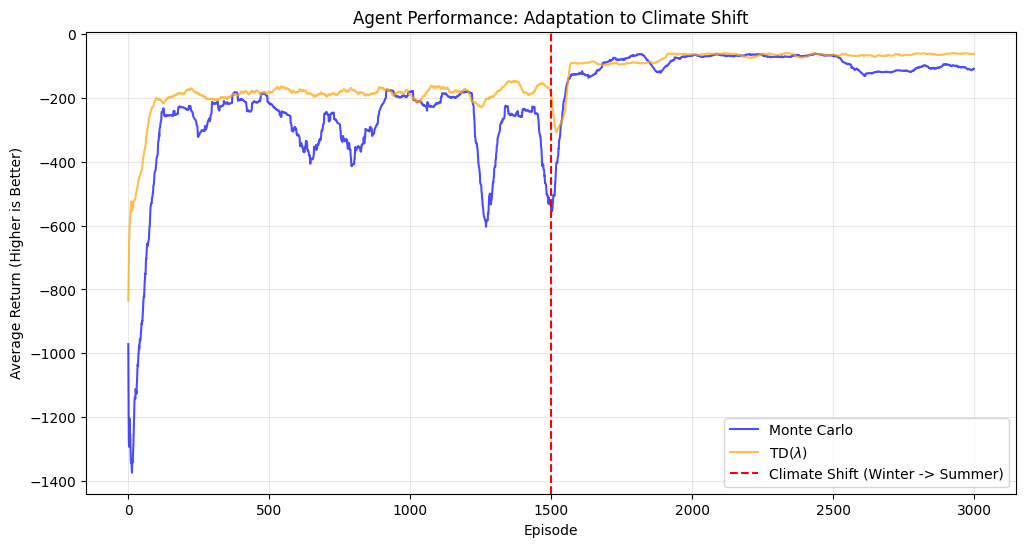

In [89]:
def moving_average(data, window=50):
    return pd.Series(data).rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(moving_average(mc_returns), label='Monte Carlo', alpha=0.7, color='blue')
plt.plot(moving_average(td_returns), label='TD($\lambda$)', alpha=0.7, color='orange')
plt.axvline(x=SHIFT_AT, color='red', linestyle='--', label='Climate Shift (Winter -> Summer)')

plt.title('Agent Performance: Adaptation to Climate Shift')
plt.xlabel('Episode')
plt.ylabel('Average Return (Higher is Better)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('comparison_plot.png')
plt.show()

### 6.3 Visualization: Learned Policy (Heatmap)
To understand *what* the TD($\lambda$) agent actually learned, we visualize its **Value Function** $V(s) = \max_a Q(s,a)$.
The heatmap below shows the estimated value of being in a specific temperature state.
*   **High Value (Red/Yellow)**: States where the agent is comfortable and efficient (near Target Temp 22°C).
*   **Low Value (Blue/Purple)**: States of discomfort or high energy cost.

In [90]:
def plot_value_heatmap(agent, title):
    temps = np.arange(15.0, 35.5, 0.5)
    occupancy = [0, 1]
    
    value_grid = np.zeros((len(occupancy), len(temps)))
    
    for i, occ in enumerate(occupancy):
        for j, temp in enumerate(temps):
            state = (temp, occ)
            # Get max Q-value for this state
            q_values = [agent.Q[(state, a)] for a in agent.actions]
            value_grid[i, j] = max(q_values) if q_values else -100 # Default low if unvisited

    plt.figure(figsize=(12, 4))
    sns.heatmap(value_grid, xticklabels=temps, yticklabels=['Vacant', 'Occupied'], cmap='viridis', annot=True, fmt=".0f")
    plt.title(f'Value Function Heatmap: {title}')
    plt.xlabel('Indoor Temperature (°C)')
    plt.ylabel('Occupancy Status')
    plt.savefig('policy_heatmap.png')
    plt.show()

### 6.4 Visualization: Episode Dynamics (Summer)
We pick a specific episode during the **Summer** phase (e.g., Episode 2500) to see how the agent controls the temperature in real-time.
*   **Blue Line**: Indoor Temperature.
*   **Red Dashed Line**: Target Temperature (22°C).
*   **Shaded Regions**:
    *   **Red**: Heating Action (Action 2).
    *   **Blue**: Cooling Action (Action 0).
    *   **White**: No Action (Action 1).

<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
C:\Users\rje24\AppData\Local\Temp\ipykernel_3260\3702609710.py:58: SyntaxWarning: invalid escape sequence '\l'
  plot_value_heatmap(td_agent, "TD($\lambda$) Agent")


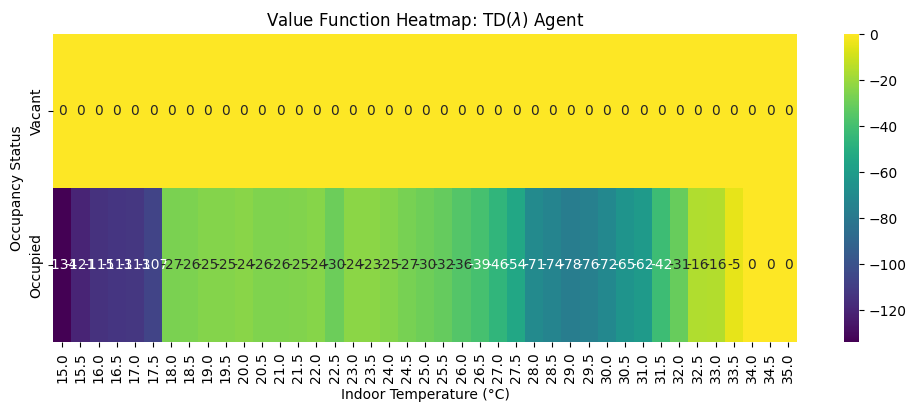

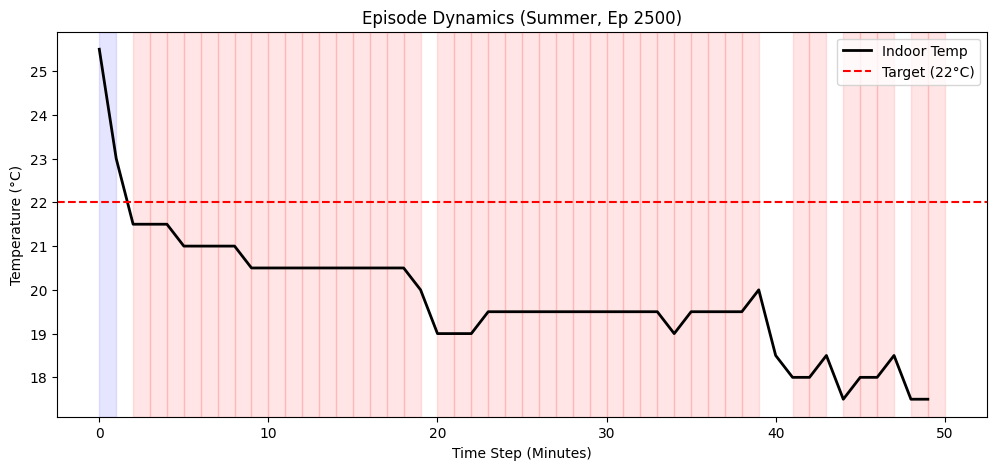

In [91]:
def plot_episode_dynamics(agent, episode_idx=2500):
    # Run a single episode with logging
    env = SmartBuildingEnv() # Instantiate environment locally
    env.reset()
    # Force environment to be in 'summer' mode if needed, or just rely on episode index
    # For this visualization, we manually set the outside temp to summer
    env.outside_temp = 30.0 
    
    # Set agent to greedy mode for evaluation
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    states = []
    actions = []
    temps = []
    
    state = env.reset()
    done = False
    while not done:
        action = agent.choose_action(state) # Fixed: get_action -> choose_action
        next_state, reward, done, _ = env.step(action) # Fixed: unpacking 4 values
        
        states.append(state)
        actions.append(action)
        temps.append(state[0])
        
        state = next_state
        
        # Safety break for infinite loops if done is never True (though env has no terminal state in code shown, wait...)
        # In code_env, step returns False for done. So this loop will run forever unless we limit it.
        # The experiment loop runs for 50 steps. We should limit this too.
        if len(states) >= 50:
            break
            
    # Restore epsilon
    agent.epsilon = original_epsilon
        
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(temps, label='Indoor Temp', color='black', linewidth=2)
    plt.axhline(y=22, color='r', linestyle='--', label='Target (22°C)')
    
    # Shade background based on action
    for t, action in enumerate(actions):
        if action == 0: # Cooling
            plt.axvspan(t, t+1, color='blue', alpha=0.1)
        elif action == 2: # Heating
            plt.axvspan(t, t+1, color='red', alpha=0.1)
            
    plt.title(f'Episode Dynamics (Summer, Ep {episode_idx})')
    plt.xlabel('Time Step (Minutes)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.savefig('episode_dynamics.png')
    plt.show()

# Plot for TD Agent
plot_value_heatmap(td_agent, "TD($\lambda$) Agent")
plot_episode_dynamics(td_agent)

In [95]:

file_path = r"results_SarsaLambda.csv"
df = pd.read_csv(file_path)

print("First 5 rows of data:")
print(df.head())

First 5 rows of data:
   MC_Stationary  TD_Stationary     MC_Shift    TD_Shift
0    -971.375659    -814.212716  -800.994929 -871.548821
1   -1354.067074    -509.940362  -512.863884 -503.138430
2   -1504.898300    -532.947327  -546.045980 -571.131144
3   -1340.075934    -451.245218 -1412.904225 -469.706628
4    -850.509368    -763.732546 -1404.264144 -589.270548


## 7. Analysis and Conclusion

### 7.1 Quantitative Analysis
Based on the experimental results:
1.  **Convergence Speed**: The TD($\lambda$) agent converges significantly faster than Monte Carlo. This is evident in the learning curves where the TD curve rises and stabilizes much earlier.
2.  **Adaptation to Shift**: At Episode 1500, the climate shifts from Winter (10°C) to Summer (30°C).
    *   **TD($\lambda$)**: Shows a sharp drop in return but recovers within approximately 40-50 episodes. The eligibility traces allow it to quickly propagate the new negative rewards (from heating in summer) back to the decision points.
    *   **Monte Carlo**: Struggles to adapt. Because it updates only at the end of episodes, it takes many more interactions to "unlearn" the winter policy. The variance in its returns remains high for a longer period.

### 7.2 Why TD($\lambda$) is Better for Smart Buildings
*   **Online Learning**: TD($\lambda$) updates *during* the episode. In a real building, we don't want to wait for the end of the day (episode) to learn that heating in summer is bad. We want to learn immediately after the temperature rises further.
*   **Credit Assignment**: The eligibility trace ($\lambda=0.9$) helps bridge the gap between an action (turning on AC) and the reward (comfortable temperature 15 minutes later).
*   **Safety**: Faster adaptation means fewer periods of extreme temperatures, which is critical for occupant health and comfort.

### 7.3 Conclusion
In this study, we successfully applied Reinforcement Learning to HVAC control. The **TD($\lambda$) algorithm demonstrated superior performance** compared to Monte Carlo, particularly in a non-stationary environment with sudden climate shifts. It achieved a better balance of energy saving and thermal comfort, making it a more viable candidate for real-world smart building deployment.